In [1]:
import sys
sys.path.append(r'..\\')
from ioMicro import *

In [206]:
!dir

 Volume in drive C is Data
 Volume Serial Number is 2400-B378

 Directory of C:\Scripts\NMERFISH\Human

07/28/2023  12:33 PM    <DIR>          .
07/28/2023  12:33 PM    <DIR>          ..
07/27/2023  09:11 AM    <DIR>          .ipynb_checkpoints
07/07/2023  12:27 PM         2,201,960 2_ComputeCellSegmentation_HumanSVZMER_6_26_2023.ipynb
07/07/2023  12:32 PM         3,646,093 2_Compute_cell_segmentationHttHumanSonia.ipynb
07/22/2023  01:45 PM           170,034 3_PullFovsCellsTogether_HttHuman_Snonia__06_12_2023.ipynb
07/06/2023  12:12 PM           166,412 3_PullFovsCellsTogether_RoyHumanSVZ.ipynb
06/30/2023  06:28 AM           212,461 CGBB_ChrX_01_31_2023_PostAnalysis-AD-low_th.ipynb
06/30/2023  06:28 AM        17,159,800 CGBB_ChrX_01_31_2023_PostAnalysis_Additional-AD.ipynb
07/27/2023  09:57 AM            89,232 CheckEachFovSVZ.ipynb
07/22/2023  01:51 PM             9,788 HumanSVZMER_6_26_2023_P1G1.py
07/28/2023  07:07 AM             9,788 HumanSVZMER_6_26_2023_P1G2.py
07/26/2023  08:04

In [9]:
fl = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Drift\driftNew_Conv_zscan__264--_set1.pkl'
drft,flds,fov,fl_ref = np.load(fl,allow_pickle=True)
drftT = [drf[0] for drf in drft]

In [136]:
save_folders = [r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group1',
               r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group2',
               r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group3',
               r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group4',
               r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group5',
               r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\MERFISH_Analysis_group6']
scoresRef = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\scoresRef.npy'
drift_folder = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Drift'
segm_tag = 'H0_'
segm_folder = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Segmentation'

th=-1.5
ncols=2
tag_save='finaldecs_'
force=True
save_folder_all = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Combined'
fov='Conv_zscan__220'
set_='_set1'
plt_val=False
ifovs = [264,265,266,275,276,277,279,280,281,
 263,268,267,274,273,278,283,282,311,
 257,269,270,271,272,285,284,309,310,
 256,251,250,249,287,286,307,308,220,305,304,224,226,225,210,211,209,195,196,180,183,180,181,176,
 8,9,13,12,14,42,16,40,41,38,39,45,37,47,46,48,57,56,52]
for ifov in ifovs:
    try:
        fov='Conv_zscan__'+str(ifov).zfill(3)
        
        if type(scoresRef) is str: scoresRef = np.load(scoresRef,allow_pickle=True)
        save_fl = save_folder_all+os.sep+os.sep+tag_save+fov.split('.')[0]+'--'+set_+'.npz'
        if not os.path.exists(save_fl) or force:
            
            if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
            
        
            ### Load point data ###############################
            all_gns_names = []
            XFF,genesFF = None,None
            for isave,save_folder in enumerate(save_folders):
                #save_folder = save_folders[0]
                dec = decoder_simple(save_folder,fov,set_)
                loaded = dec.load_decoded()
                if not loaded:
                    print(save_fl, "Did not have a valid decoded file.")
                    #return None
                dec.gns_names = np.array([gn+'_'+str(isave) if gn in all_gns_names else gn for gn in dec.gns_names])
                all_gns_names = np.unique(np.concatenate([all_gns_names,dec.gns_names]))
            
                ### Threshold point data ###############################
                dec.ncols=ncols
                get_score_withRef(dec,scoresRef,plt_val=plt_val,gene=None,iSs = None)
                dec.th=th
                if plt_val:
                    plot_statistics(dec)
                #print(dec.gns_ordered)


                ### Load dapi
                dec.fl_dapi = segm_folder+os.sep+fov+'--'+segm_tag+set_+'--dapi_segm.npz'
                dic = np.load(dec.fl_dapi)
                im_segm = dic['segm']
                dec.shape = dic['shape']
                
                dec.im_segm_=stitch3d_new(im_segm,minsz = 200,maxsz = 1000,th_int=0.66,th_cover=0.8,th_max_subcell=0.66,nexpand = 5)
                dec.shapesm = np.array(dec.im_segm_.shape)






                
                keepf =  dec.scoreA>dec.th ### keep good score
                icodesf = dec.icodesN[keepf]
                XHfpr = dec.XH_pruned[keepf]
            
                ### Reorganize data  ###############################
                XHf = np.mean(XHfpr,axis=1)
                XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
                #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
                XF[:,-1] = dec.scoreA[keepf]
                XF[:,-2] = np.where(keepf)[0]
                mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
                XF[:,-3]=mnD
                mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
                XF[:,-4]=mnH
                genesf = dec.gns_names[icodesf]
            
                ### Load and apply drift correction
                def get_drft_dic(fl_all_drift):
                    drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
                    return {'--'.join(fld.split(os.sep)[-2:]):drft_[0] for fld,drft_ in zip(flds,drft)}
                fl_all_drift = drift_folder+os.sep+'driftNew_'+fov+'--'+set_+'.pkl'
                drft_dic_all = get_drft_dic(fl_all_drift)
                fl_all_drift = save_folder+os.sep+'driftNew_'+fov+'--'+set_+'.pkl'
                drft_dic_group = get_drft_dic(fl_all_drift)
                key_segm = [key for key in drft_dic_all if segm_tag in key][0]
                key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
                th1_to_h0 = drft_dic_all[key_segm]-drft_dic_all[key_align]
                th1_gr = drft_dic_group[key_align]
                tzxyf = th1_gr+th1_to_h0
                XF[:,:3]=XF[:,:3]-tzxyf
                if XFF is None:
                    XFF,genesFF = XF,genesf
                else:
                    XFF,genesFF = np.concatenate([XFF,XF]),np.concatenate([genesFF,genesf])
                    
           
        
            def get_cell_id(dec,Xh):
                if not hasattr(dec,'im_segm_'): 
                    good = np.ones(len(Xh),dtype=bool)
                    cells_ = np.zeros(len(Xh),dtype=int)
                    return cells_,good
                im_segm = dec.im_segm_
                dec.shapesm = dec.im_segm_.shape
                Xcms = Xh[:,:3]
                Xred = np.round((Xcms/dec.shape)*dec.shapesm).astype(int)
                good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
                Xred = Xred[good]
                return im_segm[tuple(Xred.T)],good
        
            XF,genesf = XFF,genesFF  
            cell_id,good = get_cell_id(dec,XF)
            XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
            genesf_ = genesf[good]
            iset = int(dec.set_.split('_set')[-1])
            ifov = int(dec.fov.split('_')[-1].split('.')[0])
            isets = np.array([iset]*len(cell_id))[:,np.newaxis]
            ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
            cell_id = cell_id[:,np.newaxis]
            XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)
        
            get_xyfov(dec)
            XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1]]
            XF_[:,-2:]=dec.xfov,dec.yfov
            header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                      'index_from_XH_pruned','score','cell_id','ifov','iset','xfov','yfov']
            
            if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//4)
            icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            #icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            cellinfo = cms[:,[0,0,0,1,2,0,0]]
            cellinfo[:,0]=icells
            cellinfo[:,1]=vols
            cellinfo[:,-2:]=dec.xfov,dec.yfov
            header_cells = ['cell_id','volm','zc','xc','yc','xfov','yfov']
            if True:
                np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                    genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
            print("Finished",fov)
    except:
        print("Failed",fov)

Loaded decoded: -0.20106267929077148
Loaded decoded: -0.4879875183105469
Loaded decoded: -0.6905224323272705
Loaded decoded: -0.5366058349609375
Loaded decoded: -0.4633333683013916
Loaded decoded: -0.31468772888183594
Finished Conv_zscan__264
Loaded decoded: -0.17599916458129883
Loaded decoded: -0.39228343963623047
Loaded decoded: -0.633979082107544
Loaded decoded: -0.5600035190582275
Loaded decoded: -0.4869852066040039
Loaded decoded: -0.30365943908691406
Finished Conv_zscan__265
Loaded decoded: -0.12799835205078125
Loaded decoded: -0.3860132694244385
Loaded decoded: -0.4879879951477051
Loaded decoded: -0.40427732467651367
Loaded decoded: -1.0964186191558838
Loaded decoded: -0.26399803161621094
Finished Conv_zscan__266
Loaded decoded: -0.4808342456817627
Loaded decoded: -0.27804064750671387
Loaded decoded: -0.3599975109100342
Loaded decoded: -0.3199887275695801
Loaded decoded: -0.2799980640411377
Loaded decoded: -0.167999267578125
Finished Conv_zscan__275
Loaded decoded: -0.0957581996

In [132]:
np.unique(dec.im_segm_,return_counts=True)

(array([0.]), array([3937500], dtype=int64))

In [182]:
ifovs = [264,265,266,275,276,277,279,280,281,
 263,268,267,274,273,278,283,282,311,
 257,269,270,271,272,285,284,309,310,
 256,251,250,249,287,286,307,308,220,305,304,224,226,225,210,211,209,195,196,180,183,180,181,176,
 8,9,13,12,14,42,16,40,41,38,39,45,37,47,46,48,57,56,52]

In [174]:
fls = glob.glob(r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\H0__set1\*.xml')
xys = []
for fl in tqdm(fls):
    txt = open(fl,'r').read()
    xyfov = eval(txt.split('<stage_position type="custom">')[-1].split('<')[0])
    xys.append(xyfov)
xys = np.array(xys)

100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 95.72it/s]


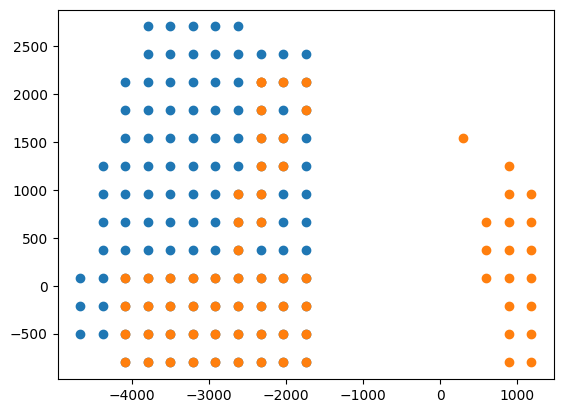

In [188]:
keep = xys[:,0]<-1700
plt.plot(xys[keep,0],xys[keep,1],'o')
plt.plot(xys[ifovs,0],xys[ifovs,1],'o')


In [193]:
print(list(np.setdiff1d(np.where(keep)[0],ifovs)))

[177, 178, 179, 182, 188, 194, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 212, 213, 214, 221, 222, 223, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 252, 253, 254, 255, 258, 259, 260, 261, 262, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 306]


In [126]:
save_fls = glob.glob(r"\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Combined\finaldecs_*")
#print(save_fl)

In [128]:
icellsf

array([], dtype=int32)

In [137]:
save_fls_ = [fl for fl in save_fls if ('_set1' in fl)]# in fl if '035' in fl][0]
cell_df,df=None,None
for save_fl in tqdm(np.sort(save_fls_)[:]):
    ### load info
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = dic['header_cells']
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-1.5
    ugns,gns_i = np.unique(genes_decoded[keep],return_inverse=True)

    icell = header.index('cell_id')
    icells = XF[keep,icell].astype(int)
    
    icellsf = cells[:,0].astype(int)
    if len(icellsf):
        mcell = np.max(icellsf)+1
        gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells,return_counts=True)
        len(gn_cell)
        igns_ = gn_cell//mcell
        icells_ = gn_cell%mcell
        Mcts = np.zeros([mcell,len(ugns)])
        Mcts[icells_,igns_]=gn_cell_cts
    
        Mcts[icellsf].shape
        ifov,iset = int(XF[0,header.index('ifov')]),int(XF[0,header.index('iset')])
        icellsnm = [icell+10**5*ifov for icell in icellsf]#icellsnm = [icell+10**5*ifov+10**9*iset for icell in icellsf]
    
        dfT = pd.DataFrame(Mcts[icellsf],columns=ugns,index=icellsnm)
    
    
        df = dfT if df is None else pd.concat([df,dfT])
        cell_dfT = pd.DataFrame(cells,columns=header_cells,index=icellsnm)
        cell_df = cell_dfT if cell_df is None else pd.concat([cell_df,cell_dfT])
    else:
        print("No cells in:",save_fl)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [01:23<00:00,  1.22s/it]


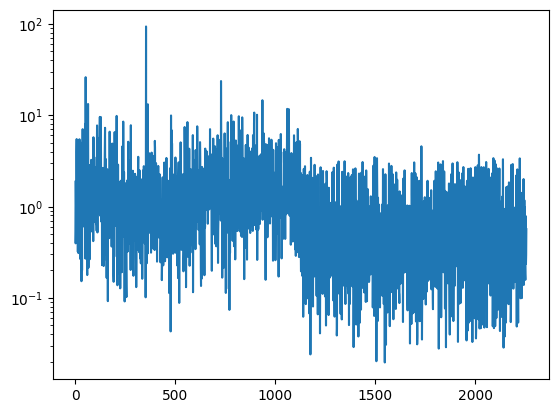

In [138]:
plt.semilogy(np.nanmean(df,axis=0))

,AAAS,AARD,ABCB1,ABI3BP,ACAT2,ACTA1,ACTA2,ACTB,ACTC,ACTG1,...,blank0186_2,blank0186_3,blank0186_4,blank0186_5,blank0187,blank0187_3,blank0187_4,blank0187_5,blank0188,blank0188_5
800001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
800002,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
800003,5.0,0.0,0.0,1.0,5.0,4.0,9.0,4.0,0.0,0.0,...,2.0,4.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
800004,4.0,0.0,0.0,1.0,2.0,7.0,14.0,2.0,1.0,3.0,...,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
800005,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31100249,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31100250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31100251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31100252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
save_folder = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\final_spots'
if not os.path.exists(save_folder): os.makedirs(save_folder)
df.to_pickle(save_folder+r'\HumanSVZMER_6_26_2023_set1_df_newCellSeg.pkl')
cell_df.to_pickle(save_folder+r'\HumanSVZMER_6_26_2023_set1_cell_df_newCellSeg.pkl')

In [147]:
          
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,pixel_size = 0.10833*4,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20):
    xcells = cell_df['xc']*pixel_size-cell_df['xfov']
    ycells = cell_df['yc']*pixel_size-cell_df['yfov']

    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    
    cts[np.isnan(cts)]=0
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    XC = -Xcells[good_cells,::-1]
    viewer = napari.view_points(XC,size=size,face_color=cols[good_cells],name=gene)
    if plt_fov:
        ifovs = np.array(list(df.index),dtype=int)//10**5
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.1f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)

In [205]:
plot_gene_mosaic_cells(df,cell_df,'DCX',plt_fov=False,pixel_size = 0.10833*4,transpose=1,nmax=30)

In [112]:
gns,cts = np.unique(genesf_,return_counts=True)
#list(gns)

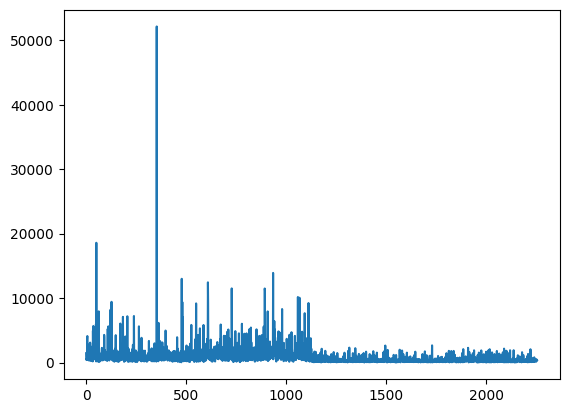

In [115]:
plt.plot(cts)

In [104]:
fls = glob.glob(r'C:\Scripts\NMERFISH\codebooks\codebook_Sonia2colorP*_group*_blank.csv')

gns = [[gn for gn in list(pd.read_csv(fl)['name']) if 'blank' not in gn] for fl in fls]
[[len(np.intersect1d(gn1,gn2))for gn1 in gns] for gn2 in gns]

[[188, 0, 0, 0, 0, 0],
 [0, 187, 0, 0, 0, 0],
 [0, 0, 187, 0, 0, 0],
 [0, 0, 0, 188, 0, 0],
 [0, 0, 0, 0, 189, 0],
 [0, 0, 0, 0, 0, 189]]

In [106]:
print(list(np.unique(all_gns_names)))

['AAAS', 'AARD', 'ABCB1', 'ABI3BP', 'ACAT2', 'ACTA1', 'ACTA2', 'ACTB', 'ACTC', 'ACTG1', 'ACTL6B', 'ACTN1', 'ADAMTS17', 'ADAMTS2', 'ADAMTS9-AS2', 'ADAMTSL1', 'ADAMTSL3', 'ADARB2', 'ADGRG1', 'ADGRV1', 'AEBP1', 'AGFG1', 'AGPAT3', 'AGPAT5', 'AHCTF1', 'AHI1', 'AHNAK2', 'AIM2', 'AKAP6', 'AKIRIN1', 'AKT3', 'ALDH1A1', 'ALDH1L1', 'ALOX5', 'ALOX5AP', 'AMBP', 'ANK2', 'ANK3', 'ANKRD17', 'ANLN', 'ANXA11', 'ANXA2', 'ANXA4', 'AP2B1', 'APAF1', 'APBB1IP', 'APLP2', 'APOC1', 'APOD', 'APOE', 'APOO', 'APP', 'AQP1', 'AQP4', 'ARHGEF11', 'ARL17B', 'ARPP21', 'ASGR2', 'ASIC2', 'ASIC4', 'ATOH8', 'ATP11B', 'ATP13A4', 'ATP1A2', 'ATP1B1', 'ATP1B3', 'ATP2A3', 'ATP5E', 'ATP5G2', 'ATP6AP2', 'ATP6V1F', 'ATP7B', 'ATP8A2', 'ATP8B4', 'ATPIF1', 'B2M', 'BAD', 'BANF1', 'BARX1', 'BAX', 'BCAS1', 'BCHE', 'BCL-X', 'BCL2', 'BEAN1', 'BEX1', 'BEX2', 'BICD2', 'BMP2', 'BRAP', 'BRCA1', 'BRCA2', 'BRIP1', 'BSPRY', 'C1ORF132', 'C1ORF172', 'C1QB', 'C1QC', 'C1QL3', 'C2CD5', 'C4ORF26', 'C8orf34', 'C9ORF142', 'C9ORF72', 'CA1', 'CA10', 'CA2',

In [67]:
segm_tag = 'H0_'
segm_folder = r'\\192.168.0.127\Raw_data\Roy\HumanSVZMER_6_26_2023\Segmentation'


(166986, 11)

In [ ]:
cell_id,good = get_cell_id(dec,XF)

In [80]:
Xcms = XF[:,:3]-tzxyf
Xred = np.round((Xcms/dec.shape)*dec.shapesm).astype(int)
import napari
v = napari.Viewer()
v.add_labels(dec.im_segm_)
v.add_points(Xred,size=0.5)

<Points layer 'Xred' at 0x25d07460ca0>

In [ ]:
Conv_zscan__324--H0__set1--dapi_segm.npz

In [ ]:
def save_final_decoding(save_folder,fov,set_,scoresRef,th=-1.5,ncols=3,
                        tag_save = 'finaldecs_',
                        plt_val=False,apply_flat=True,
                        tags_smFISH=['Aldh','Sox11'],
                        genes_smFISH=[['Igfbpl1','Aldh1l1','Ptbp1'],['Sox11','Sox2','Dcx']],Hths=None,force=False,try_mode=True):
    """
    This loads the decoded points renormalizes them and picks the most confident points
    """
    if type(scoresRef) is str: scoresRef = np.load(scoresRef,allow_pickle=True)
    dec = decoder_simple(save_folder,fov,set_)
    save_fl = dec.save_folder+os.sep+os.sep+tag_save+dec.fov.split('.')[0]+'--'+dec.set_+'.npz'
    if not os.path.exists(save_fl) or force:
        #print(dec.fov,dec.set_)
        def main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force):
            nsegm = load_segmentation(dec)
            loaded = dec.load_decoded()
            if not loaded:
                print(save_fl, "Did not have a valid decoded file.")
                return None
            if apply_flat:
                apply_flat_field(dec)
            apply_fine_drift(dec,plt_val=plt_val)
            
            #for i in range(3):
            #    apply_brightness_correction(dec)
            #get_scores(dec,plt_val=plt_val)
            dec.ncols=ncols
            get_score_withRef(dec,scoresRef,plt_val=plt_val,gene=None,iSs = None)
            dec.th=th
            #plot_1gene(dec,gene='Gad1',viewer = None)
            if plt_val:
                viewer = plot_multigenes(dec,genes=['Adcy1','Slc1a2','Psap'],colors=['r','g','b','m','c','y','w'],viewer = None,
                                         smin=1,smax=2.5,drift=dec.drift[0],
                                        resc = dec.shape/dec.im_segm_.shape)
                viewer.add_labels(dec.im_segm_);
            if plt_val:
                plot_statistics(dec)
            #print(dec.gns_ordered)

            keepf =  dec.scoreA>dec.th ### keep good score
            icodesf = dec.icodesN[keepf]
            XHfpr = dec.XH_pruned[keepf]
            XHf = np.mean(XHfpr,axis=1)
            if Hths is None:
                ICol = XHfpr[:,:,-2].astype(int)
                Hths = [np.percentile(XHfpr[ICol==icol][:,-3],15) for icol in np.unique(ICol)]
            
            XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
            #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
            XF[:,-1] = dec.scoreA[keepf]
            XF[:,-2] = np.where(keepf)[0]
            mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
            XF[:,-3]=mnD
            mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
            XF[:,-4]=mnH
            genesf = dec.gns_names[icodesf]
            
            ### deal with smFISH
            for tag_smFISH,gns_smFISH in zip(tags_smFISH,genes_smFISH):
                dec.get_XH_tag(tag=tag_smFISH)#dec.get_XH_tag(tag='Aldh1')
                if len(dec.Xh.shape)>1:
                    if len(dec.Xh)>0:
                        if apply_flat:
                            Xh = norm_brightness(dec,dec.Xh)
                        else:
                            Xh = dec.Xh

                        tags = [gn+'_smFISH' for gn in gns_smFISH]#['Igfbp_smFISH','Aldh1l1_smFISH','Ptbp1_smFISH']

                        for icol,tag_gn in enumerate(tags):
                            Xh_ = Xh[Xh[:,-2]==icol]
                            Xh_=Xh_[Xh_[:,-3]>Hths[icol]]
                            Xh_=Xh_[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
                            Xh_[:,-1]=0
                            Xh_[:,-2]=-1
                            Xh_[:,-3]=0
                            Xh_[:,-4]=0
                            XF = np.concatenate([XF,Xh_])
                            genesf = np.concatenate([genesf,[tag_gn]*len(Xh_)])

            cell_id,good = get_cell_id(dec,XF)
            XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
            genesf_ = genesf[good]
            iset = int(dec.set_.split('_set')[-1])
            ifov = int(dec.fov.split('_')[-1].split('.')[0])
            isets = np.array([iset]*len(cell_id))[:,np.newaxis]
            ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
            cell_id = cell_id[:,np.newaxis]
            XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

            get_xyfov(dec)
            XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1]]
            XF_[:,-2:]=dec.xfov,dec.yfov
            header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                      'index_from_XH_pruned','score','cell_id','ifov','iset','xfov','yfov']
            
            if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//4)
            icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            #icells,vols = np.unique(dec.im_segm_,return_counts=True)
            cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
            cellinfo = cms[:,[0,0,0,1,2,0,0]]
            cellinfo[:,0]=icells
            cellinfo[:,1]=vols
            cellinfo[:,-2:]=dec.xfov,dec.yfov
            header_cells = ['cell_id','volm','zc','xc','yc','xfov','yfov']

            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        if try_mode:
            try:
                main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force)
            except:
                print("Failed",dec.fov,dec.set_)
        else:
            main_subf(dec,save_fl,save_folder,fov,set_,scoresRef,th,ncols,plt_val,apply_flat,tags_smFISH,genes_smFISH,Hths,force)
    

In [84]:
get_xyfov(dec)

In [7]:
flds

['\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate1\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate1\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate2\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate2\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate3\\H1_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\plate3\\H13_MER_set1',
 '\\\\192.168.0.127\\Raw_data\\Roy\\HumanSVZMER_6_26_2023\\H0__set1']